Figure 3: Sea Ice Concentration Poster Stamps

In [13]:
# Load modules
%pylab inline
from netCDF4 import Dataset # to work with NetCDF files
import numpy as np
import matplotlib.pyplot as plt # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
from os.path import expanduser
home = expanduser("~") # Get users home directory
import os # operating system interface
import scipy as sp
import xarray as xr
from xarray.ufuncs import square, sqrt
import scipy.interpolate
import scipy.ndimage
#import seawater as sw

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['square', 'sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
client = Client(n_workers=4)
client

/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:42439 Dashboard: /proxy/35633/status,Cluster Workers: 4 Cores: 96 Memory: 1.60 TB


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [15]:
#extract the MOM model grid info - 50 and 75 vertical levels
hgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print(geolon_t.shape)

fh=fcor/ht
print(fh.shape)

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print(st_ocean.shape)
print(potrho.shape)
print(yt_ocean.shape)


(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [16]:
#A = xr.DataArray(np.arange(100))
#A.cumsum(axis=0)
print (xr.__version__)

0.11.0


In [17]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0_wp2/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'output19*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print(cntrl_i.CN.shape)
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

#Ocean_File = os.path.join(NYFCntrlDir,'output*/ocean__*.nc')
#print(Ocean_File)
#cntrl=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
#print(cntrl.mld.shape)

Ocean_File = os.path.join(NYFPertDir,'output*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print(pert_i.CN.shape)
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ocean__*.nc')
print(Ocean_File)
pert=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print(pert.mld.shape)

#print nyf_cn.shape
#print pert_cn.shape
#cn = np.concatenate((nyf_cn[0:12,:],pert_cn),axis=0)
#print cn.shape

(348, 5, 1080, 1440)
(528, 5, 1080, 1440)
/g/data/v45/pas561/mom/archive/wombat_jul15b_r0_wp2/output*/ocean__*.nc
(44, 1080, 1440)


In [18]:
#NaN the land values for masking
#yr=0
#tst=cntrl_i.CN[yr*12+i,:,:].sum('ct').load()
#print tst.shape
#print 'tst', tst[50:150,1276]

#mask area_t for land cells.
msk=np.zeros((kmt.shape[0],kmt.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmt>=1)]=1
#print msk.shape
#tst=tst*msk
#print 'tst', tst[50:150,1276]




In [19]:

clev3 = np.arange(2000,2001,1000)
#print clev3
clev2 = np.arange(0,1,1)
#print clev2


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
[2000]
[0.2]


/g/data3/hh5/public/apps/miniconda3/envs/analysis27-18.10/lib/python2.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'clevels'
  s)


TypeError: Input z must be a 2D array.

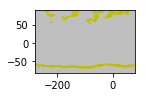

In [20]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print(tits)

numyrs=7
ii=0

clev3 = np.arange(2000,2001,1000)
print(clev3)

clev2 = np.arange(0.20,0.21,1)
print(clev2)
        
for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')
        
        #CMRmap_r
        
        #if yr==0:
        #    p1=plt.contour(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        #else:
        #    p1=plt.contour(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        
        if yr==0:
            p1=plt.contour(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
        else:
            p1=plt.contour(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
             
        if yr==0:
            p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[0:9,:,:].mean('Time').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        else:
            p1=plt.contourf(xt_ocean,yt_ocean,(pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load())*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        
        #if yr==0:
            #contour(X,Y,en_slp2d,levels=clev3,colors='k',linewidths=1)
         #   p2=plt.contour(xt_ocean,yt_ocean,cntrl.mld[0:9,:,:].mean('Time').load()*msk,clevels=clev3,colors='y',linewidths=1)
        #else:
        #    p2=plt.contour(xt_ocean,yt_ocean,pert.mld[yr,:,:].load()*msk,clevels=clev3,colors='y',linewidths=1)
        
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-57))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='b) MOM025_NoNP\n'+tits[i-5]
                print(titstr)
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
##ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
#of = '/g/data1/v45/pas561/mom/archive/wp2_figs/Fig3b_CN.png'
#plt.savefig(of,dpi=220)


In [37]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'Tdim_output197*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl_i.CN.shape)
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print(pert_i.CN.shape)
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape

(108, 5, 1080, 1440)
(612, 5, 1080, 1440)


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
a) MOM025_NP
Aug.


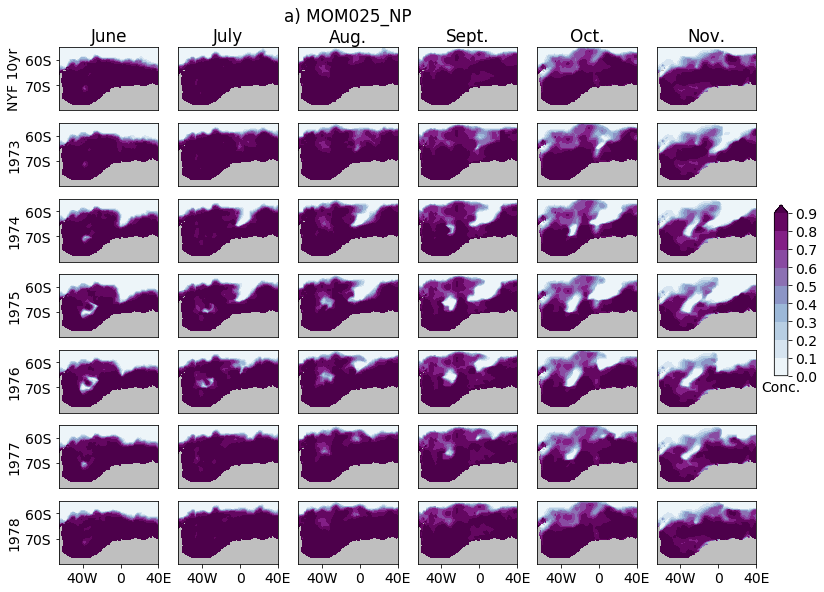

In [38]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print(tits)


ii=0

for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')
        
        if yr==0:
            p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        else:
            p1=plt.contourf(xt_ocean,yt_ocean,(pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load())*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
            
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='a) MOM025_NP\n'+tits[i-5]
                print(titstr)
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig3a_CN.png'
plt.savefig(of,dpi=220)


In [42]:
NYFCntrlDir = '/g/data/hh5/tmp/pas561/kds75_cp/'
#NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/3yr/'
NYFPertDir = '/g/data/hh5/tmp/pas561/kds75_wp2/2yr/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'CN.cat.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape

Ocean_File = os.path.join(NYFPertDir,'CN.cat2.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN.shape

vgrid_file ='/g/data/hh5/tmp/pas561/kds75_cp/output430/ocean.nc'

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean = nc.variables['yt_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the file
print yt_ocean.shape





(201, 5, 2700, 3600)
(234, 5, 2700, 3600)
(2700,)


In [43]:
# Extract the variables
hgrid_file ='/g/data/v45/pas561/mom/archive/mom01_unmasked_ocean_grid.nc'
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
kmt = nc.variables['kmt'][:]
nc.close() # close the file
print(kmt.shape)

#NaN the land values for masking
#yr=0
#tst=cntrl_i.CN[yr*12+i,:,:].sum('ct').load()
#print tst.shape
#print 'tst', tst[50:150,1276]

#mask area_t for land cells.
msk=np.zeros((kmt.shape[0],kmt.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmt>=1)]=1
#print msk.shape
#tst=tst*msk
#print 'tst', tst[50:150,1276]

(2700, 3600)


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
c) MOM01 2yr
Aug.


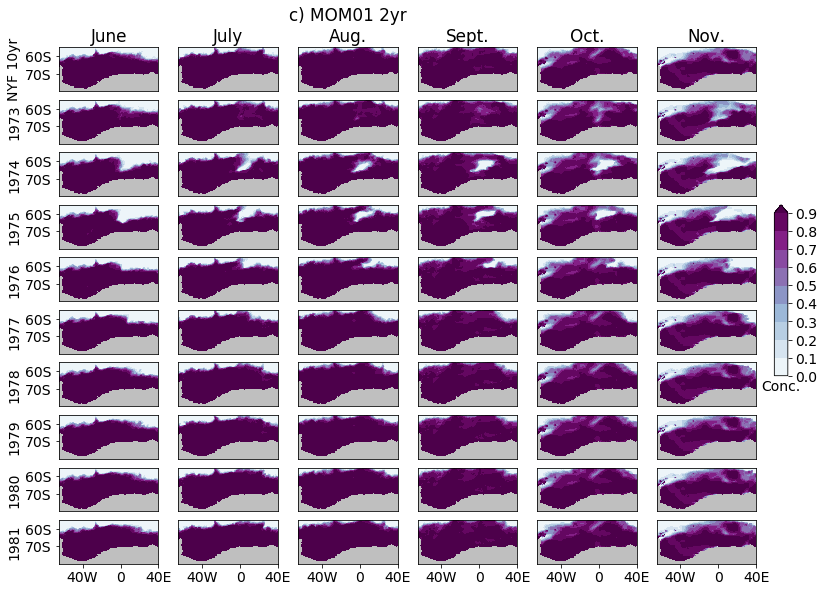

In [44]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits


ii=0

numyrs=10
for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')

        if yr==0:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],cntrl_i.CN[t1,:,0:1000,:].sum('ct').load()*msk[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
        elif yr==1:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load()*msk[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
        else:
            t1=(yr-1)*12+i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load()*msk[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
    
        
        #if yr==0:
        #    p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='both')
        #else:
        #    p1=plt.contourf(xt_ocean,yt_ocean,(pert_i.CN[(yr-1)*12+i,:,:].sum('ct').load())*msk,cmap=plt.cm.BuPu,levels=clev,extend='both')
            
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='c) MOM01 2yr\n'+tits[i-5]
                print titstr
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig3c_CN.png'
plt.savefig(of,dpi=220)


In [45]:
#https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-overview-comparison-table-and-graphs

#https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-hadisst
#this data gets a few maude polynyas .. but not a lot
#monthy sic from 1870/01 to 2018/10

#http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.html
#try this data source once trump get fucked

In [46]:
# Extract the variables
ice_file ='/g/data/v45/pas561/mom/archive/wp2_figs/HadISST_ice.cat.nc'
nc = Dataset(ice_file, mode='r') # file handle, open in read only mode
had_sic = nc.variables['sic'][:]
had_sic = nc.variables['sic'][:]
had_lon = nc.variables['longitude'][:]
had_lat = nc.variables['latitude'][:]
nc.close() # close the file
print(had_sic.shape, had_lat.shape, had_lon.shape)

((1798, 180, 360), (180,), (360,))


In [47]:
#print had_lon
clev2 = np.arange(0.2,0.21,1)
print(clev2)

[0.2]


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
[2000]
[0.3]
b) HadISST
Aug.


Text(0.5,0,'Conc.')

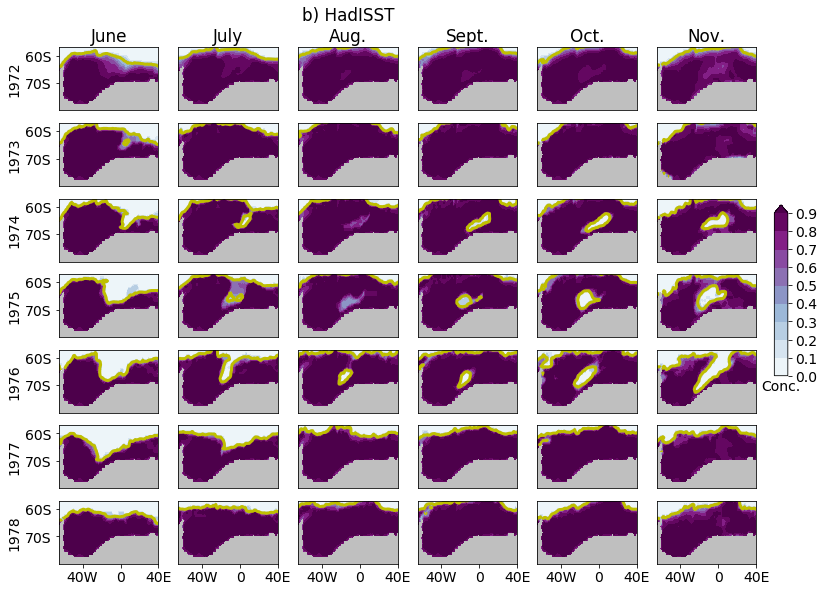

In [48]:
#(1972-1870+1)*12=1236
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print(tits)

numyrs=7
ii=0

clev3 = np.arange(2000,2001,1000)
print(clev3)

clev2 = np.arange(0.30,0.31,1)
print(clev2)

cnt=1972-1870

for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')
        
        #CMRmap_r
        
        p1=plt.contourf(had_lon,had_lat,had_sic[(cnt+yr)*12+i,:,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
        p2=plt.contour(had_lon,had_lat,had_sic[(cnt+yr)*12+i,:,:],levels=clev2,colors='y',linewidths=3)
        
        #if yr==0:
        #    p1=plt.contour(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
        #else:
        #    p1=plt.contour(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
             
        #if yr==0:
            #contour(X,Y,en_slp2d,levels=clev3,colors='k',linewidths=1)
         #   p2=plt.contour(xt_ocean,yt_ocean,cntrl.mld[0:9,:,:].mean('Time').load()*msk,clevels=clev3,colors='y',linewidths=1)
        #else:
        #    p2=plt.contour(xt_ocean,yt_ocean,pert.mld[yr,:,:].load()*msk,clevels=clev3,colors='y',linewidths=1)
        
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-57))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='b) HadISST\n'+tits[i-5]
                print(titstr)
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            plt.ylabel(yrs[yr])
            plt.gca().axes.get_yaxis().set_ticks([-70, -60])
            plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
#of = '/g/data1/v45/pas561/mom/archive/wp2_figs/Fig3b_CN.png'
#plt.savefig(of,dpi=220)



In [49]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'Tdim_output197*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert_i.CN.shape
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape

(108, 5, 1080, 1440)
(612, 5, 1080, 1440)


In [50]:
hgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print(geolon_t.shape)

fh=fcor/ht
print(fh.shape)

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print(st_ocean.shape)
print(potrho.shape)
print(yt_ocean.shape)

(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [51]:
#mask area_t for land cells.
msk=np.zeros((kmt.shape[0],kmt.shape[1]),dtype=float)
msk.fill(np.nan)
msk[np.where(kmt>=1)]=1


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
[0.2]
1972 control np  5
1972 had  1229
1972 control np  6
1972 had  1230
1972 control np  7
1972 had  1231
a) MOM025_NP
Aug.
1972 control np  8
1972 had  1232
1972 control np  9
1972 had  1233
1972 control np  10
1972 had  1234
1973 pert np  5
1973 had  1241
1973 pert np  6
1973 had  1242
1973 pert np  7
1973 had  1243
1973 pert np  8
1973 had  1244
1973 pert np  9
1973 had  1245
1973 pert np  10
1973 had  1246
1974 pert np  17
1974 had  1253
1974 pert np  18
1974 had  1254
1974 pert np  19
1974 had  1255
1974 pert np  20
1974 had  1256
1974 pert np  21
1974 had  1257
1974 pert np  22
1974 had  1258
1975 pert np  29
1975 had  1265
1975 pert np  30
1975 had  1266
1975 pert np  31
1975 had  1267
1975 pert np  32
1975 had  1268
1975 pert np  33
1975 had  1269
1975 pert np  34
1975 had  1270
1976 pert np  41
1976 had  1277
1976 pert np  42
1976 had  1278
1976 pert np  43
1976 had  1279
1976 pert np  44
1976 had  1280
1976 pert np  45
1976 

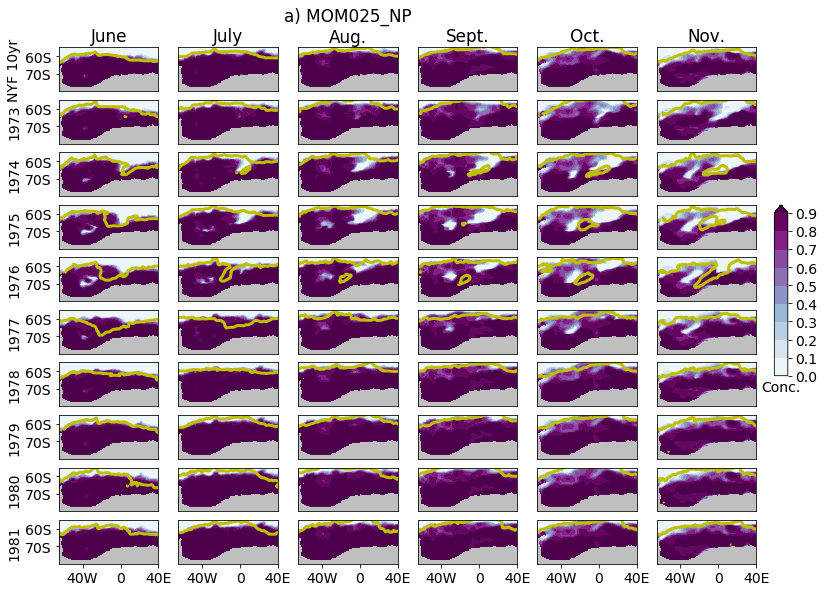

In [52]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits

clev2 = np.arange(0.20,0.21,1)
print clev2

ii=0
numyrs=10

for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')
        
        if yr==0:
            p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
            print yrs[yr],'control np ',yr*12+i
        else:
            p1=plt.contourf(xt_ocean,yt_ocean,(pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load())*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
            print yrs[yr],'pert np ',(yr-1)*12+i
            
        p2=plt.contour(had_lon,had_lat,had_sic[(1972-1870+yr)*12+i,:,:],levels=clev2,colors='y',linewidths=3)
        print yrs[yr],'had ',(1972-1870+yr)*12+i
        
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='a) MOM025_NP\n'+tits[i-5]
                print titstr
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig3a_CN.png'
plt.savefig(of,dpi=220)


In [53]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0/'
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jul15b_r0_wp2/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'output19*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print cntrl_i.CN.shape
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

Ocean_File = os.path.join(NYFPertDir,'output*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert_i.CN.shape
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape


(348, 5, 1080, 1440)
(528, 5, 1080, 1440)


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
[2000]
[0.2]
b) MOM025_NoNP
Aug.


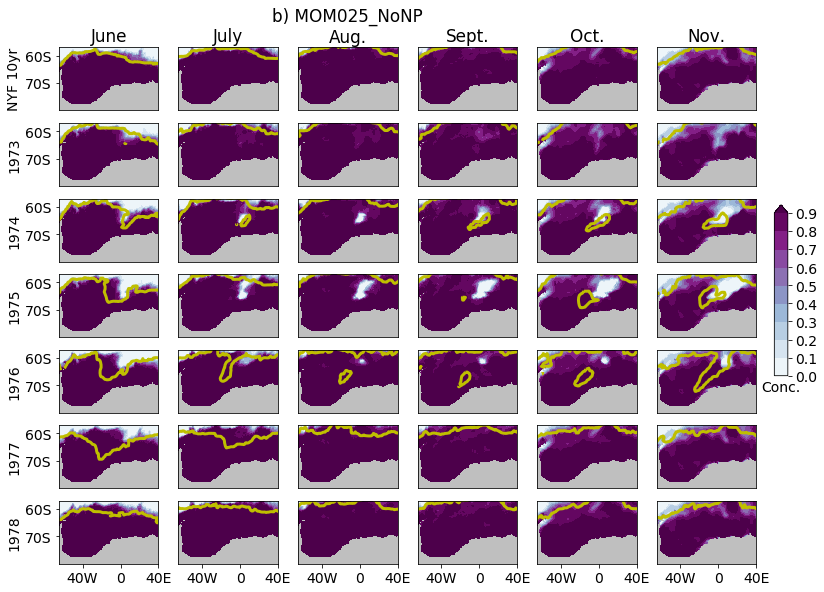

In [54]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits

numyrs=7
ii=0

clev3 = np.arange(2000,2001,1000)
print clev3

clev2 = np.arange(0.20,0.21,1)
print clev2

for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')
        
        #CMRmap_r
        
        if yr==0:
            p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        else:
            p1=plt.contourf(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='max')
        
        p2=plt.contour(had_lon,had_lat,had_sic[(1972-1870+yr)*12+i,:,:],levels=clev2,colors='y',linewidths=3)
        #if yr==0:
        #    p1=plt.contour(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
        #else:
        #    p1=plt.contour(xt_ocean,yt_ocean,pert_i.CN[(yr-1)*12+i,:,:,:].sum('ct').load()*msk,clevels=clev2,colors='y',linewidths=1)
             
        #if yr==0:
            #contour(X,Y,en_slp2d,levels=clev3,colors='k',linewidths=1)
         #   p2=plt.contour(xt_ocean,yt_ocean,cntrl.mld[0:9,:,:].mean('Time').load()*msk,clevels=clev3,colors='y',linewidths=1)
        #else:
        #    p2=plt.contour(xt_ocean,yt_ocean,pert.mld[yr,:,:].load()*msk,clevels=clev3,colors='y',linewidths=1)
        
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-57))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='b) MOM025_NoNP\n'+tits[i-5]
                print titstr
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig3b_CN.png'
plt.savefig(of,dpi=220)


In [56]:
NYFCntrlDir = '/g/data3/hh5/tmp/pas561/kds75_cp/'
#NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/3yr/'
NYFPertDir = '/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'CN.cat.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape

Ocean_File = os.path.join(NYFPertDir,'CN.cat2.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print pert_i.CN.shape

vgrid_file ='/g/data3/hh5/tmp/pas561/kds75_cp/output430/ocean.nc'

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean = nc.variables['yt_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the file
print yt_ocean.shape

(201, 5, 2700, 3600)
(234, 5, 2700, 3600)
(2700,)


In [57]:
# Extract the variables
hgrid_file ='/g/data/v45/pas561/mom/archive/mom01_unmasked_ocean_grid.nc'
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
kmt = nc.variables['kmt'][:]
nc.close() # close the file
print kmt.shape

#NaN the land values for masking
#yr=0
#tst=cntrl_i.CN[yr*12+i,:,:].sum('ct').load()
#print tst.shape
#print 'tst', tst[50:150,1276]

#mask area_t for land cells.
msk_01=np.zeros((kmt.shape[0],kmt.shape[1]),dtype=float)
msk_01.fill(np.nan)
msk_01[np.where(kmt>=1)]=1
#print msk.shape
#tst=tst*msk
#print 'tst', tst[50:150,1276]

(2700, 3600)


['June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.']
[0.2]
1972 pert 01  2
1972 pert 01  3
1972 pert 01  4
c) MOM01 2yr
Aug.
1972 pert 01  5
1972 pert 01  6
1972 pert 01  7
1973 pert 01  2
1973 pert 01  3
1973 pert 01  4
1973 pert 01  5
1973 pert 01  6
1973 pert 01  7
1974 pert 01  14
1974 pert 01  15
1974 pert 01  16
1974 pert 01  17
1974 pert 01  18
1974 pert 01  19
1975 pert 01  26
1975 pert 01  27
1975 pert 01  28
1975 pert 01  29
1975 pert 01  30
1975 pert 01  31
1976 pert 01  38
1976 pert 01  39
1976 pert 01  40
1976 pert 01  41
1976 pert 01  42
1976 pert 01  43
1977 pert 01  50
1977 pert 01  51
1977 pert 01  52
1977 pert 01  53
1977 pert 01  54
1977 pert 01  55
1978 pert 01  62
1978 pert 01  63
1978 pert 01  64
1978 pert 01  65
1978 pert 01  66
1978 pert 01  67


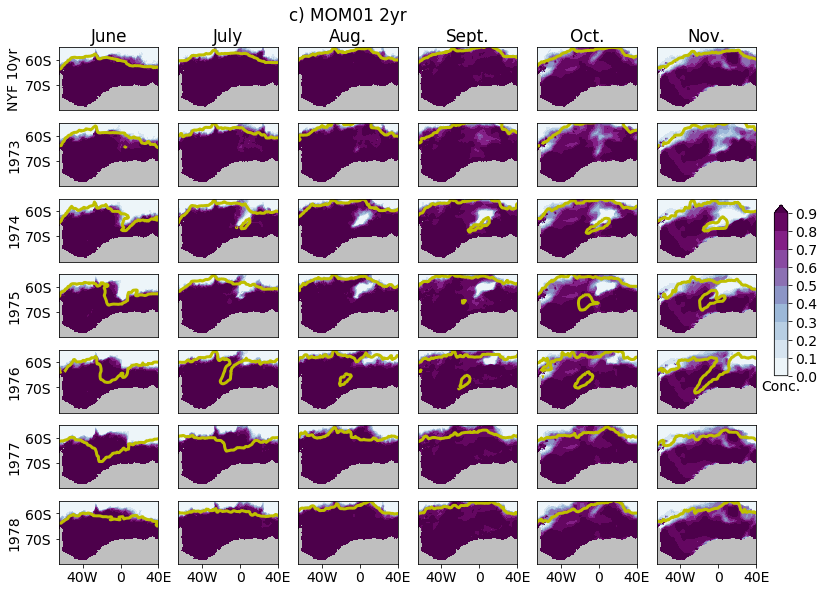

In [58]:
plt.figure(figsize(12.5,9.5))
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
#plt.suptitle('b) MOM025_NoNP')

tits=['June','July','Aug.','Sept.','Oct.', 'Nov.']
yrs=np.arange(1972,2016,1)
print tits


ii=0

clev2 = np.arange(0.20,0.21,1)
print clev2

numyrs=7
for yr in range(0,numyrs):
    #print yr
    for i in range(5,11): 
        
        #print yr*12+i
    
        clev = np.arange(0,1,.1)
        plt.subplot(numyrs,6,ii+1)
        plt.gca().patch.set_color('.75')

        if yr==0:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],cntrl_i.CN[t1,:,0:1000,:].sum('ct').load()*msk_01[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
        elif yr==1:
            #starts in april 
            t1=i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load()*msk_01[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
        else:
            t1=(yr-1)*12+i-3
            p1=plt.contourf(xt_ocean,yt_ocean[0:1000],pert_i.CN[t1,:,0:1000,:].sum('ct').load()*msk_01[0:1000,:],cmap=plt.cm.BuPu,levels=clev,extend='max')
    
        print yrs[yr],'pert 01 ',t1
        p2=plt.contour(had_lon,had_lat,had_sic[(1972-1870+yr)*12+i,:,:],levels=clev2,colors='y',linewidths=3)
        
        #if yr==0:
        #    p1=plt.contourf(xt_ocean,yt_ocean,cntrl_i.CN[yr*12+i,:,:].sum('ct').load()*msk,cmap=plt.cm.BuPu,levels=clev,extend='both')
        #else:
        #    p1=plt.contourf(xt_ocean,yt_ocean,(pert_i.CN[(yr-1)*12+i,:,:].sum('ct').load())*msk,cmap=plt.cm.BuPu,levels=clev,extend='both')
            
        #cb=plt.colorbar(orientation='vertical',shrink = 0.7)
        #cb.ax.set_xlabel('Conc.')
        #clev3 = np.arange(0,5000,1000)
        #plt.contour(xt_ocean,yt_ocean,ht,levels=clev3,colors='k',linewidths=0.25)
        plt.gca().yaxis.set_major_formatter(x_formatter)
        plt.ylim((-80,-55))
        #plt.xlabel('Longitude ($^\circ$)')
        
        plt.xlim([-65,40])
        
        if yr==0:
            if i==7:
                titstr='c) MOM01 2yr\n'+tits[i-5]
                print titstr
                plt.title(titstr)
            else:
                plt.title(tits[i-5])
           
        if yr==numyrs-1:
            plt.gca().axes.get_xaxis().set_ticks([-40, 0, 40])
            plt.gca().axes.set_xticklabels(['40W', '0', '40E'])
            #plt.xticks([-60, -40, -20, 0, 20, 40])
        else:
            plt.gca().axes.get_xaxis().set_ticks([])
            
        if i==5:
            if yr==0:
                plt.ylabel('NYF 10yr')
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])
            else:
                plt.ylabel(yrs[yr])
                plt.gca().axes.get_yaxis().set_ticks([-70, -60])
                plt.gca().axes.set_yticklabels(['70S', '60S'])    
        else:
            plt.gca().axes.get_yaxis().set_ticks([])
            
        ii+=1

ax3 = plt.axes([0.92,0.4,0.015,0.25])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
#ticks=[0, 500, 1000, 1500, 2000]
cb.ax.set_xlabel('Conc.')


#plt.text(1.05, 0.5, 'b) MOM025_NoNP')

#of = os.path.join(NYFPertDir,'cn.pdf')
#print of
#plt.savefig(of)
of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig3c_CN.png'
plt.savefig(of,dpi=220)


In [70]:
#1974
tmp1=pert_i.CN[16:19,:,:,:].sum('ct').mean(dim='time').load()
tmp2=pert_i.CN[28:31,:,:,:].sum('ct').mean(dim='time').load()
tmp3=pert_i.CN[40:43,:,:,:].sum('ct').mean(dim='time').load()

pert_i_01_7476=(tmp1+tmp2+tmp3)/3*msk_01

In [71]:
#1974
tmp1=cntrl_i.CN[16:19,:,:,:].sum('ct').mean(dim='time').load()
tmp2=cntrl_i.CN[28:31,:,:,:].sum('ct').mean(dim='time').load()
tmp3=cntrl_i.CN[40:43,:,:,:].sum('ct').mean(dim='time').load()

cntrl_i_01_7476=(tmp1+tmp2+tmp3)/3*msk_01

In [72]:
vgrid_file ='/g/data3/hh5/tmp/pas561/kds75_cp/output430/ocean.nc'

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
yt_ocean_01 = nc.variables['yt_ocean'][:]
xt_ocean_01 = nc.variables['xt_ocean'][:]
#potrho = nc.variables['potrho'][:]
#dzt = nc.variables['dzt'][:]
nc.close() # close the file
print yt_ocean_01.shape

(2700,)


In [73]:
#calculate sea ice area time-series

In [74]:
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'Tdim_output197*/ice__*.nc')
cntrl_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print cntrl_i.CN.shape
#nyf_cn=ff.CN.sum('ct').load()
#print nyf_cn.shape

cntrl_i

(108, 5, 1080, 1440)


<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 108, xb: 1441, xt: 1440, xv: 1440, yb: 1081, yt: 1080, yv: 1080)
Coordinates:
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * xb           (xb) float64 -280.0 -279.8 -279.5 -279.3 ... 79.53 79.77 80.0
  * yt           (yt) float64 -81.08 -80.97 -80.87 -80.76 ... 78.84 78.84 78.85
  * yb           (yb) float64 -81.13 -81.02 -80.92 -80.81 ... 78.84 78.85 78.85
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * nv           (nv) float64 1.0 2.0
  * xv           (xv) float64 -279.8 -279.5 -279.3 -279.1 ... 79.53 79.77 80.0
  * yv           (yv) float64 -81.02 -80.92 -80.81 -80.71 ... 78.84 78.85 78.85
Dimensions without coordinates: time
Data variables:
    Time         (time) float64 dask.array<shape=(108,), chunksize=(12,)>
    CN           (time, ct, yt, xt) float32 dask.array<shape=(108, 5, 1080, 1440), chunksize=(12, 5, 1080, 1440)>
    EXT          (time, yt, xt) float32 dask.array<shape=(10

In [75]:
Ocean_File = os.path.join(NYFCntrlDir,'ice.CN.cat.80sto10s.all.nc')
print Ocean_File
cntrl2_i=xr.open_dataset(Ocean_File,engine='netcdf4',decode_times=False)
#cntrl2_i.rename({'time': 'Time'})
print cntrl2_i.CN.shape
cntrl2_i

/g/data/v45/pas561/mom/archive/wombat_jun16z/ice.CN.cat.80sto10s.all.nc
(480, 5, 1080, 1440)


<xarray.Dataset>
Dimensions:      (ct: 5, nv: 2, time: 480, xt: 1440, yt: 1080)
Coordinates:
  * xt           (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * yt           (yt) float64 -81.08 -80.97 -80.87 -80.76 ... 78.84 78.84 78.85
  * ct           (ct) float64 0.0 0.1 0.3 0.7 1.1
  * time         (time) float64 7.302e+04 7.304e+04 ... 7.295e+04 7.298e+04
Dimensions without coordinates: nv
Data variables:
    CN           (time, ct, yt, xt) float32 ...
    time_bounds  (time, nv) float64 ...
Attributes:
    filename:   ice__2000_01.nc
    title:      mom5_0p25global_bgc
    grid_type:  mosaic
    grid_tile:  1
    history:    Fri Feb  4 16:23:03 2022: ncrcat ice.CN.2000s.cat.nc ice.CN.2...
    NCO:        netCDF Operators version 4.9.9 (Homepage = http://nco.sf.net,...

In [76]:
#this has 3 years of a wind perturbation - get a nice 3 year polynya.
NYFPertDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/'

Ocean_File = os.path.join(NYFPertDir,'output*/ice__*.nc')
pert_i=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='Time',decode_times=False)
print pert_i.CN.shape
#pert_cn=ff.CN.sum('ct').load()
#print pert_cn.shape

(612, 5, 1080, 1440)


In [77]:
print pert_i.CN.Time

<xarray.DataArray 'Time' (Time: 612)>
array([63160.5, 63190. , 63219.5, ..., 81683.5, 81714. , 81744.5])
Coordinates:
  * Time     (Time) float64 6.316e+04 6.319e+04 ... 8.171e+04 8.174e+04
Attributes:
    long_name:       Time
    units:           days since 1800-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   NOLEAP
    calendar:        NOLEAP
    bounds:          Time_bounds


In [78]:
hgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/mom025_ocean_grid.nc'
vgrid_file ='/g/data3/hh5/tmp/pas561/gfdl_nyf_1080/ocean.ncra501-520.nc'

# Extract the variables
nc = Dataset(hgrid_file, mode='r') # file handle, open in read only mode
geolon_t = nc.variables['geolon_t'][:]
geolat_t = nc.variables['geolat_t'][:]
area_t = nc.variables['area_t'][:]
dxt = nc.variables['dxt'][:]
dyt = nc.variables['dyt'][:]
kmu = nc.variables['kmu'][:]
kmt = nc.variables['kmt'][:]
ht = nc.variables['ht'][:]
fcor = nc.variables['f_coriolis'][:]
nc.close() # close the file
print(geolon_t.shape)

fh=fcor/ht
print(fh.shape)

nc = Dataset(vgrid_file, mode='r') # file handle, open in read only mode
sw_ocean = nc.variables['sw_ocean'][:]
st_ocean = nc.variables['st_ocean'][:]
yt_ocean = nc.variables['yt_ocean'][:]
yu_ocean = nc.variables['yu_ocean'][:]
xt_ocean = nc.variables['xt_ocean'][:]
potrho = nc.variables['potrho'][:]
nc.close() # close the file
print(st_ocean.shape)
print(potrho.shape)
print(yt_ocean.shape)

(1080, 1440)
(1080, 1440)
(50,)
(80,)
(1080,)


In [79]:
#mask area_t for land cells.
msk_np=np.zeros((kmt.shape[0],kmt.shape[1]),dtype=float)
msk_np.fill(np.nan)
msk_np[np.where(kmt>=1)]=1


In [80]:
#1974
yr=2
print (yr-1)*12+7,(yr-1)*12+10
tmp1=pert_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='Time').load()
#1975
yr=3
print (yr-1)*12+7,(yr-1)*12+10
tmp2=pert_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='Time').load()
#1976
yr=4
print (yr-1)*12+7,(yr-1)*12+10
tmp3=pert_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='Time').load()

pert_i_np_7476=(tmp1+tmp2+tmp3)/3*msk_np

19 22
31 34
43 46


In [81]:
#1974
yr=2
print (yr-1)*12+7,(yr-1)*12+10
tmp1=cntrl_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='time').load()
#1975
yr=3
print (yr-1)*12+7,(yr-1)*12+10
tmp2=cntrl_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='time').load()
#1976
yr=4
print (yr-1)*12+7,(yr-1)*12+10
tmp3=cntrl_i.CN[(yr-1)*12+7:(yr-1)*12+10,:,:,:].sum('ct').mean(dim='time').load()

cntrl_i_np_7476=(tmp1+tmp2+tmp3)/3*msk_np

19 22
31 34
43 46


In [82]:
#calculate annual mean sea ice area in wedell sea
pert_np_cn_area=pert_i.CN.sum('ct').compute()*area_t
pert_np_cn_area

<xarray.DataArray 'CN' (Time: 612, yt: 1080, xt: 1440)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       ...,

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]],

       [[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * xt       (xt) float64 -279.9 -279.7 -279.4 -279.2 ... 79.42 79.65 79.88
  * yt       (yt) float64 -81.08 -80.97 -80.87 -80.76 ... 78.84 78.84 78.85
  * Time     (Time) float64 6.316e+04 6.319e+04 ... 8.171e+04 8.174e+04

In [83]:
#yt_ocean<-55, xt_ocean>-63,xt_ocean<-40 
print yt_ocean[300],xt_ocean[870],xt_ocean[960]
pert_np_cn_area_wed=pert_np_cn_area[:,0:300,870:960].sum(dim='yt').sum(dim='xt')/1000/1000
print pert_np_cn_area_wed.shape

tmp=np.array(np.split(pert_np_cn_area_wed,12))
print(tmp.shape)
pert_np_cn_area_wed_ann=np.mean(tmp,axis=0)
print pert_np_cn_area_wed_ann

-44.19977917334686 -62.375 -39.875
(612,)
(12, 51)
[936061.   980813.5  974045.75 938398.94 979434.44 975038.06 939494.56
 980584.56 969799.75 942528.2  982632.2  971345.44 936731.75 981767.5
 972947.44 938580.44 980027.7  974674.44 939059.44 981694.56 975395.
 941412.44 979696.06 966088.56 938461.8  980920.25 968275.3  936399.7
 978546.3  970906.2  935143.8  978159.7  974036.2  938530.5  976476.5
 961802.25 937333.2  978874.5  963132.3  932664.25 976695.25 968754.2
 932027.7  975110.   971735.5  935259.25 974822.25 962430.7  937713.94
 978515.75 963302.5 ]


In [84]:
pert_np_cn_area_wed_ann.shape

(51,)

In [85]:
cntrl_np_cn_area=cntrl_i.CN.sum('ct').compute()*area_t

cntrl_np_cn_area_wed=cntrl_np_cn_area[:,0:300,870:960].sum(dim='yt').sum(dim='xt')/1000/1000
print cntrl_np_cn_area_wed.shape

tmp=np.array(np.split(cntrl_np_cn_area_wed,12))
print(tmp.shape)
cntrl_np_cn_area_wed_ann=np.mean(tmp,axis=0)
print cntrl_np_cn_area_wed_ann

(108,)
(12, 9)
[934042.3  977780.94 965061.8  934289.8  977961.25 965222.06 934138.06
 977580.94 964578.7 ]


In [ ]:
cntrl2_np_cn_area=cntrl2_i.CN.sum('ct').compute()*area_t

cntrl2_np_cn_area_wed=cntrl2_np_cn_area[:,0:300,870:960].sum(dim='yt').sum(dim='xt')/1000/1000
print cntrl2_np_cn_area_wed.shape

tmp=np.array(np.split(cntrl2_np_cn_area_wed,12))
print(tmp.shape)
cntrl2_np_cn_area_wed_ann=np.mean(tmp,axis=0)
print cntrl2_np_cn_area_wed_ann

In [ ]:
print cntrl_np_cn_area_wed_ann.shape, cntrl2_np_cn_area_wed_ann.shape

In [ ]:
cntrl_np_cn_area_wed_ann=np.concatenate((cntrl_np_cn_area_wed_ann,cntrl2_np_cn_area_wed_ann))

In [ ]:
cntrl_np_cn_area_wed_ann.shape

In [87]:
#HadISST
#see prints above ...
#1974
#yr=2
#print (1972-1870+yr)*12+7,(1972-1870+yr)*12+10
tmp1=np.mean(had_sic[1255:1258,:,:],axis=0)
tmp2=np.mean(had_sic[1267:1270,:,:],axis=0)
tmp3=np.mean(had_sic[1279:1282,:,:],axis=0)


had_sic_7476=(tmp1+tmp2+tmp3)/3
had_sic_7476.shape

(180, 360)

In [111]:
yrs[0]

1971

In [88]:
fi='/home/561/pas561/gdv45/mom/archive/wp2_figs/hadi_cn_ann_area_wed_140_200.npy'
print(fi)

hadi=np.load(fi)

/home/561/pas561/gdv45/mom/archive/wp2_figs/hadi_cn_ann_area_wed_140_200.npy


In [125]:
fi='/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/pert_01_cn_ann_area_wed_19702405_3005.npy'
print(fi)
pert_01=np.load(fi)
print(pert_01.shape)

#fix missing data
pert_01[37]=pert_01[38]
pert_01[42]=pert_01[41]

#extend missing last 2 years
pert_01=np.append(pert_01,pert_01[40])
pert_01=np.append(pert_01,pert_01[38])
print(pert_01.shape)


/g/data3/hh5/tmp/pas561/kds75_wp2/2yr/pert_01_cn_ann_area_wed_19702405_3005.npy
(43,)
(45,)


In [126]:
fi='/g/data3/hh5/tmp/pas561/kds75_cp/cntrl_01_cn_ann_area_wed_19702405_3005.npy'
cntrl_01=np.load(fi)
print(cntrl_01.shape)

#extend missing last 2 years
cntrl_01=np.append(cntrl_01,cntrl_01[40])
cntrl_01=np.append(cntrl_01,cntrl_01[38])
print(cntrl_01.shape)


(43,)
(45,)


In [120]:
fi='/g/data/v45/pas561/mom/archive/wombat_jun16z_wp2_74/pert_np_cn_ann_area_wed_1970_961_1201.npy'
pert_np=np.load(fi)

In [121]:
fi='/g/data/v45/pas561/mom/archive/wombat_jun16z/cntrl_np_cn_ann_area_wed_1970_961_1201.npy'
print(fi)
cntrl_np=np.load(fi)

/g/data/v45/pas561/mom/archive/wombat_jun16z/cntrl_np_cn_ann_area_wed_1970_961_1201.npy


# HadISST annual mean sea ice data starting in 1870
ice_file ='/g/data/v45/pas561/mom/archive/wp2_figs/HadISST_ice.cat.ann.nc'
hadisst_ann=xr.open_dataset(ice_file,engine='netcdf4',decode_times=False)
print(hadisst_ann.sic.shape, hadisst_ann.latitude.shape, hadisst_ann.longitude.shape)
hadisst_ann.sic

#hadisst_ann.sic[(1980-1870):,:,:].mean(axis=0).plot()
NYFCntrlDir = '/g/data/v45/pas561/mom/archive/wombat_jun16z/'

#plot stamps of sea ice concentration.
Ocean_File = os.path.join(NYFCntrlDir,'ice.CN.Tdim.cat.all.nc'); #'Tdim_output197*/ice__*.nc')
cntrl_i_np=xr.open_mfdataset(Ocean_File,engine='netcdf4',concat_dim='time',decode_times=False)
print(cntrl_i_np.CN.shape)

#cntrl_i_np_cn=cntrl_i_np.CN.sum('ct').compute()
#cntrl_i_np_cn

cntrl_01_cn_ann=np.load('/g/data3/hh5/tmp/pas561/kds75_cp/CN.ann.npy')
cntrl_01_cn_ann.shape

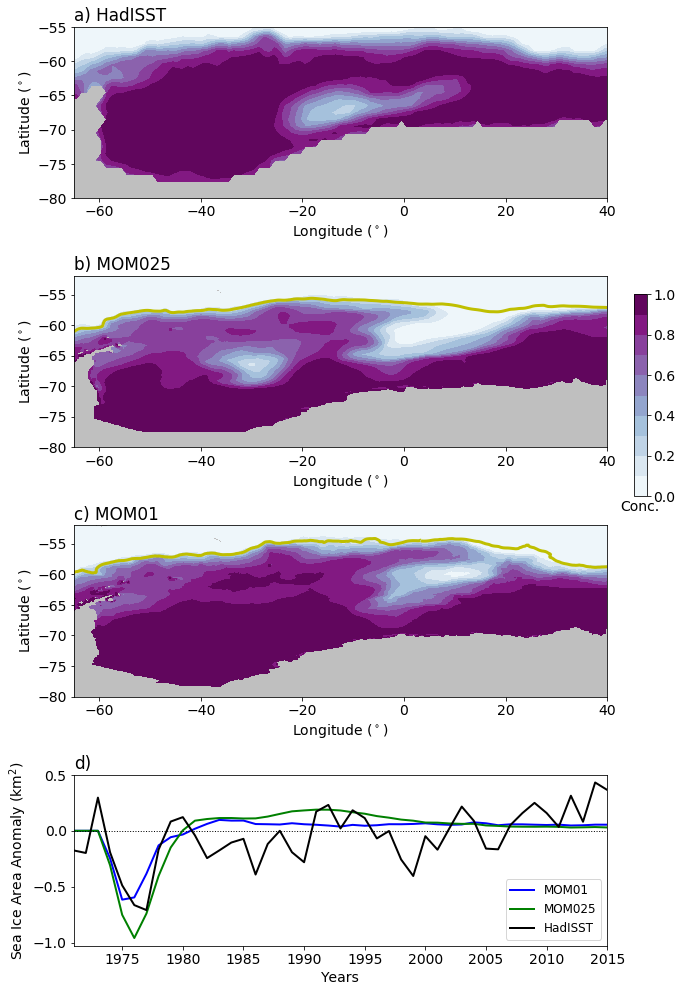

<Figure size 648x1008 with 0 Axes>

In [127]:
x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)

fontsize=14

fig, axs = plt.subplots(4, 1)

plt.rcParams['font.size'] = fontsize

plt.figure(figsize(9,14))

clev2 = np.arange(0.20,0.21,1)
#print clev2
clev = np.arange(0,1.1,.1)
tick_lvls = np.arange(0,1.1,.1)

ax = axs[0] 
ax.patch.set_color('.75')
p1=ax.contourf(had_lon,had_lat,had_sic_7476,cmap=plt.cm.BuPu,levels=clev,extend='neither')
#p2=ax.contour(had_lon,had_lat,hadisst_ann.sic[(1980-1870):,:,:].mean(axis=0),levels=clev2,colors='y',linewidths=3)
ax.yaxis.set_major_formatter(x_formatter)
ax.axis(ymin=-80,ymax=-55, xmin=-65,xmax=40) 
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_ylabel('Latitude ($^\circ$)')
tit='a) HadISST'
ax.set_title(tit,loc='left')


ax = axs[1] #plt.subplot(311)
ax.patch.set_color('.75')
p1=ax.contourf(xt_ocean,yt_ocean,pert_i_np_7476,cmap=plt.cm.BuPu,levels=clev,extend='neither')
p2=ax.contour(xt_ocean,yt_ocean,cntrl_i_np_7476,levels=clev2,colors='y',linewidths=3)
ax.yaxis.set_major_formatter(x_formatter)
ax.axis(ymin=-80,ymax=-52, xmin=-65,xmax=40) 
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_ylabel('Latitude ($^\circ$)')
tit='b) MOM025'
ax.set_title(tit,loc='left')

ax = axs[2] #plt.subplot(311)
ax.patch.set_color('.75')
p1=ax.contourf(xt_ocean_01,yt_ocean_01,pert_i_01_7476,cmap=plt.cm.BuPu,levels=clev,extend='neither')
p2=ax.contour(xt_ocean_01,yt_ocean_01,cntrl_i_01_7476,levels=clev2,colors='y',linewidths=3)
ax.yaxis.set_major_formatter(x_formatter)
ax.axis(ymin=-80,ymax=-52, xmin=-65,xmax=40) 
ax.set_xlabel('Longitude ($^\circ$)')
ax.set_ylabel('Latitude ($^\circ$)')
tit='c) MOM01'
ax.set_title(tit,loc='left')

# colorbar:
cbaxes = fig.add_axes([.99,0.5,0.02,0.2])
cb = fig.colorbar(p1,ax=axs[0:3],cax=cbaxes,orientation='vertical',extend='neither')
cb.ax.set_xlabel('Conc.')

ax = axs[3] 
yrs=np.arange(1971,2020,1)

ax.plot(yrs[0:45],(pert_01[0:45]-cntrl_01[0:45])/1E6,linestyle='-',color='b',label='MOM01',linewidth=2)
ax.plot(yrs[0:45],(pert_np[0:45]-cntrl_np[0:45])/1E6,linestyle='-',color='g',label='MOM025',linewidth=2)
ax.plot(yrs[0:45],(hadi[101:146]-np.mean(hadi[111:146]))/1E6,linestyle='-',color='k',label='HadISST',linewidth=2)
ax.plot(yrs[0:45],hadi[101:146]-hadi[101:146],linestyle=':',color='k',linewidth=1)
ax.set_ylabel('Sea Ice Area Anomaly (km$^2$) ')
ax.set_xlabel('Years')
ax.legend(fontsize=12)
ax.axis(xmin=1971,xmax=2015) 
tit='d)'
ax.set_title(tit,loc='left')

fig.tight_layout()

of = '/g/data/v45/pas561/mom/archive/wp2_figs/Fig_SIA.png'
fig.savefig(of,dpi=220,bbox_inches='tight')


In [98]:
pert_01[0:43]/1E6


array([2.9773657, 2.9840882, 2.988234 , 2.7349155, 2.3599775, 2.3892624,
       2.6068707, 2.8580103, 2.9345195, 2.9526558, 3.0005033, 3.0526066,
       3.0861368, 3.0796118, 3.0833147, 3.0652618, 3.0709324, 3.0685072,
       3.0724351, 3.0504048, 3.0425556, 3.0356538, 3.0286567, 3.0350912,
       3.0308073, 3.041748 , 3.047882 , 3.0494187, 3.0466633, 3.0431352,
       3.0392556, 3.0413356, 3.0404954, 3.0529115, 3.0433302, 3.0351648,
       3.0487583, 2.5727916, 3.046556 , 3.037464 , 3.037062 , 3.0382233,
       4.738127 ], dtype=float32)

In [103]:
pert_01[37]/1E6

2.5727915

In [99]:
cntrl_01[0:43]/1E6

array([2.97736575, 2.98408825, 2.988234  , 2.98123775, 2.976243  ,
       2.98553225, 2.99088   , 2.9889035 , 2.992034  , 2.98573575,
       2.98215325, 2.99091275, 2.98875375, 2.98856475, 2.991793  ,
       3.00480225, 3.01224075, 3.01224075, 3.00480225, 2.991793  ,
       2.98856475, 2.98875375, 2.99091275, 2.98215325, 2.98573575,
       2.992034  , 2.9889035 , 2.99088   , 2.98553225, 2.976243  ,
       2.98123775, 2.988234  , 2.98408825, 2.97736575, 2.976243  ,
       2.98553225, 2.99088   , 2.9889035 , 2.992034  , 2.98573575,
       2.98215325, 2.99091275, 2.98875375])